<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_1/remove_targets_from_ref.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remove target virus species, genus and family from reference index prior to performing alignment

### Install software and download data

In [1]:
!pip install -q kb_python biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 80.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 36.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.6 MB/s eta 0:00:00


In [2]:
from Bio import SeqIO
import pandas as pd
import numpy as np
from itertools import product
import kb_python.utils as kb_utils
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
from tqdm import tqdm
TQDM_BAR_FORMAT = (
    "{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]"
)

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

In [3]:
# Install kallisto from source
!git clone -q https://github.com/pachterlab/kallisto.git
!cd kallisto && mkdir build && cd build && cmake .. && make

# Install bustools from source
!git clone -q https://github.com/BUStools/bustools.git
!cd bustools && mkdir build && cd build && cmake .. && make

# Define paths to kallisto and bustools binaries
kallisto = "/content/kallisto/build/src/kallisto"
bustools = "/content/bustools/build/src/bustools"

CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Performing Test COMPILER_SUPPORTS_CXX17
-- Performing Test COMPILER_SUPPORTS_CXX17 - Success
shared build
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_P

In [4]:
# Download the customized transcripts to gene mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
# Download the RdRP amino acid sequences
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_rdrp_seqs.fa

virus_fasta = "palmdb_rdrp_seqs.fa"
virus_t2g = "palmdb_clustered_t2g.txt"

--2023-12-11 03:35:10--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4561689 (4.3M) [text/plain]
Saving to: ‘palmdb_clustered_t2g.txt’

palmdb_clustered_t2 100%[===================>]   4.35M  --.-KB/s    in 0.06s   

2023-12-11 03:35:11 (68.2 MB/s) - ‘palmdb_clustered_t2g.txt’ saved [4561689/4561689]

--2023-12-11 03:35:11--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_rdrp_seqs.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaitin

In [5]:
# Load virus ID to taxonomy mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
taxmap = pd.read_csv("ID_to_taxonomy_mapping.csv")
taxmap

--2023-12-11 03:35:13--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19705497 (19M) [text/plain]
Saving to: ‘ID_to_taxonomy_mapping.csv’

ID_to_taxonomy_mapp 100%[===================>]  18.79M  --.-KB/s    in 0.1s    

2023-12-11 03:35:13 (186 MB/s) - ‘ID_to_taxonomy_mapping.csv’ saved [19705497/19705497]



,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
296556,u296608,u296608,.,.,.,.,.,.,unknown
296557,u296609,u296609,.,.,.,.,.,.,unknown
296558,u296613,u296613,.,.,.,.,.,.,unknown
296559,u296616,u296616,.,.,.,.,.,.,unknown


In [6]:
# Get fasta file containing ZEBOV RdRP sequences
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Figure_2/Figure_2c/SRR12698539_2_extracted_u10.fa
nn_fasta = "SRR12698539_2_extracted_u10.fa"

--2023-12-11 03:35:13--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Figure_2/Figure_2c/SRR12698539_2_extracted_u10.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75549 (74K) [text/plain]
Saving to: ‘SRR12698539_2_extracted_u10.fa’

SRR12698539_2_extra 100%[===================>]  73.78K  --.-KB/s    in 0.02s   

2023-12-11 03:35:13 (3.97 MB/s) - ‘SRR12698539_2_extracted_u10.fa’ saved [75549/75549]



In [7]:
# Number of threads used for alignments
threads = 2

In [8]:
out_folder = "remove_targets_from_ref"
!mkdir $out_folder

____
# Remove all sequences linked to the genus *Ebolavirus* from the reference index

Create new fasta excluding all sequences associated with the Ebolavirus genus:

In [9]:
targets_all = taxmap[taxmap["genus"].str.contains("Ebolavirus")]["ID"].values

In [10]:
%%time
records = SeqIO.parse(virus_fasta, "fasta")

test_fasta = f"{out_folder}/uniques_nodup_targets_removed.fa"
with open(test_fasta, "w") as new_fasta:
    for record in records:
        if record.id not in targets_all:
            new_fasta.write(">" + record.id + "\n")
            new_fasta.write(str(record.seq) + "\n")

CPU times: user 3.31 s, sys: 98.7 ms, total: 3.41 s
Wall time: 3.42 s


Generate reference index using this new fasta:

In [11]:
virus_index = f"{out_folder}/uniques_nodup_targets_removed.idx"

!$kallisto index \
    --aa \
    -t $threads \
    -i $virus_index \
    $test_fasta


[build] loading fasta file remove_targets_from_ref/uniques_nodup_targets_removed.fa
[build] k-mer length: 31
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Finished
CompactedDBG::build(): Estimated number of k-mers occurring at least once: 37640331
CompactedDBG::build(): Estimated number of minimizer occurring at least once: 7877361
CompactedDBG::filter(): Processed 87606558 k-mers in 296482 reads
CompactedDBG::filter(): Found 37506262 unique k-mers
CompactedDBG::filter(): Number of blocks in Bloom filter is 257308
CompactedDBG::construct(): Extract approximate unitigs (1/2)
CompactedDBG::construct(): Extract approximate unitigs (2/2)
CompactedDBG::construct(): Closed all input files

CompactedDBG::construct(): Splitting unitigs (1/2)

CompactedDBG::construct(): Splitting unitigs (2/2)
CompactedDBG::construct(): Before split: 2040316 unitigs
CompactedD

Align ZEBOV RdRP nucleotide sequences to the new index:

In [12]:
!$kallisto bus \
        --aa \
        -i $virus_index \
        -o $out_folder/kallisto \
        -x bulk \
        -t $threads \
        $nn_fasta

!$bustools sort -o $out_folder/kallisto/output_sorted.bus $out_folder/kallisto/output.bus

!$bustools count \
    --genecounts \
    --cm \
    -o $out_folder/kallisto/bustools_count/ \
    -g $virus_t2g \
    -e $out_folder/kallisto/matrix.ec \
    -t $out_folder/kallisto/transcripts.txt \
    $out_folder/kallisto/output_sorted.bus


[index] k-mer length: 31
[index] number of targets: 296,482
[index] number of k-mers: 37,539,216
[quant] running in single-end mode
[quant] will process file 1: SRR12698539_2_extracted_u10.fa
[quant] finding pseudoalignments for all files ... done
[quant] processed 676 reads, 127 reads pseudoaligned

 all fits in buffer
Read in 127 BUS records
reading time 5e-06s
sorting time 6e-06s
writing time 3.7e-05s


____
# Remove all sequences linked to species names containing "ebolavirus" from the reference index

In [13]:
targets_all = taxmap[taxmap["species"].str.contains("ebolavirus")]["ID"].values

In [14]:
%%time
records = SeqIO.parse(virus_fasta, "fasta")

test_fasta = f"{out_folder}/uniques_nodup_targets_removed_2.fa"
with open(test_fasta, "w") as new_fasta:
    for record in records:
        if record.id not in targets_all:
            new_fasta.write(">" + record.id + "\n")
            new_fasta.write(str(record.seq) + "\n")

CPU times: user 3.27 s, sys: 93.7 ms, total: 3.37 s
Wall time: 3.37 s


Generate index with new fasta:

In [15]:
virus_index = f"{out_folder}/uniques_nodup_targets_removed_2.idx"

!$kallisto index \
    -t $threads \
    --aa \
    -i $virus_index \
    $test_fasta


[build] loading fasta file remove_targets_from_ref/uniques_nodup_targets_removed_2.fa
[build] k-mer length: 31
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Finished
CompactedDBG::build(): Estimated number of k-mers occurring at least once: 37640528
CompactedDBG::build(): Estimated number of minimizer occurring at least once: 7877484
CompactedDBG::filter(): Processed 87607206 k-mers in 296484 reads
CompactedDBG::filter(): Found 37506628 unique k-mers
CompactedDBG::filter(): Number of blocks in Bloom filter is 257310
CompactedDBG::construct(): Extract approximate unitigs (1/2)
CompactedDBG::construct(): Extract approximate unitigs (2/2)
CompactedDBG::construct(): Closed all input files

CompactedDBG::construct(): Splitting unitigs (1/2)

CompactedDBG::construct(): Splitting unitigs (2/2)
CompactedDBG::construct(): Before split: 2040564 unitigs
Compacte

Align fasta with ZEBOV RdRP nucleotide sequences:

In [16]:
!$kallisto bus \
        -i $virus_index \
        -o $out_folder/kallisto2 \
        --aa \
        -x bulk \
        -t $threads \
        $nn_fasta

!$bustools sort -o $out_folder/kallisto2/output_sorted.bus $out_folder/kallisto2/output.bus

!$bustools count \
    --genecounts \
    --cm \
    -o $out_folder/kallisto2/bustools_count/ \
    -g $virus_t2g \
    -e $out_folder/kallisto2/matrix.ec \
    -t $out_folder/kallisto2/transcripts.txt \
    $out_folder/kallisto2/output_sorted.bus


[index] k-mer length: 31
[index] number of targets: 296,484
[index] number of k-mers: 37,539,777
[quant] running in single-end mode
[quant] will process file 1: SRR12698539_2_extracted_u10.fa
[quant] finding pseudoalignments for all files ... done
[quant] processed 676 reads, 483 reads pseudoaligned

 all fits in buffer
Read in 483 BUS records
reading time 7e-06s
sorting time 1.6e-05s
writing time 3.9e-05s


____
# Remove sequences linked to the family *Filoviridae* from the reference index

In [17]:
targets_all = taxmap[taxmap["family"].str.contains("Filoviridae")]["ID"].values

In [18]:
%%time
records = SeqIO.parse(virus_fasta, "fasta")

test_fasta = f"{out_folder}/uniques_nodup_targets_removed_3.fa"
with open(test_fasta, "w") as new_fasta:
    for record in records:
        if record.id not in targets_all:
            new_fasta.write(">" + record.id + "\n")
            new_fasta.write(str(record.seq) + "\n")

CPU times: user 3.91 s, sys: 99.3 ms, total: 4.01 s
Wall time: 4.05 s


Generate index with new fasta:

In [19]:
virus_index = f"{out_folder}/uniques_nodup_targets_removed_3.idx"

!$kallisto index \
    -t $threads \
    --aa \
    -i $virus_index \
    $test_fasta


[build] loading fasta file remove_targets_from_ref/uniques_nodup_targets_removed_3.fa
[build] k-mer length: 31
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Finished
CompactedDBG::build(): Estimated number of k-mers occurring at least once: 37637384
CompactedDBG::build(): Estimated number of minimizer occurring at least once: 7876665
CompactedDBG::filter(): Processed 87601434 k-mers in 296466 reads
CompactedDBG::filter(): Found 37503650 unique k-mers
CompactedDBG::filter(): Number of blocks in Bloom filter is 257288
CompactedDBG::construct(): Extract approximate unitigs (1/2)
CompactedDBG::construct(): Extract approximate unitigs (2/2)
CompactedDBG::construct(): Closed all input files

CompactedDBG::construct(): Splitting unitigs (1/2)

CompactedDBG::construct(): Splitting unitigs (2/2)
CompactedDBG::construct(): Before split: 2040600 unitigs
Compacte

Align fasta with ZEBOV RdRP nucleotide sequences:

In [20]:
!$kallisto bus \
        -i $virus_index \
        -o $out_folder/kallisto3 \
        --aa \
        -x bulk \
        -t $threads \
        $nn_fasta

!$bustools sort -o $out_folder/kallisto3/output_sorted.bus $out_folder/kallisto3/output.bus

!$bustools count \
    --genecounts \
    --cm \
    -o $out_folder/kallisto3/bustools_count/ \
    -g $virus_t2g \
    -e $out_folder/kallisto3/matrix.ec \
    -t $out_folder/kallisto3/transcripts.txt \
    $out_folder/kallisto3/output_sorted.bus


[index] k-mer length: 31
[index] number of targets: 296,466
[index] number of k-mers: 37,536,591
[quant] running in single-end mode
[quant] will process file 1: SRR12698539_2_extracted_u10.fa
[quant] finding pseudoalignments for all files ... done
[quant] processed 676 reads, 142 reads pseudoaligned

 all fits in buffer
Read in 142 BUS records
reading time 4e-06s
sorting time 5e-06s
writing time 3e-05s


___
# Load results and plot which taxonomies the sequences were aligned to

Load data where all sequences linked to Ebolavirus species were removed:

In [21]:
# Filepath to counts
X = f"{out_folder}/kallisto2/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{out_folder}/kallisto2/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{out_folder}/kallisto2/bustools_count/output.barcodes.txt"

# Create AnnData object
adata2 = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
adata2

AnnData object with n_obs × n_vars = 1 × 99222

In [22]:
ids_seen2 = adata2.var[nd(adata2.X.sum(axis=0) > 0)].index.values
ids_seen2

array(['u14834', 'u102797'], dtype=object)

In [23]:
taxmap[taxmap["rep_ID"].isin(ids_seen2)]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
32024,u14834,u14834,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,.,-ssRNA
32025,u190559,u14834,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,.,-ssRNA
218192,u102797,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218193,u1158,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218194,u15480,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218195,u15788,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218196,u20644,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218197,u21217,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218198,u424,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218199,u444,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA


Load alignment data where all sequences linked to Ebolavirus genera were removed from the reference:

In [24]:
# Filepath to counts
X = f"{out_folder}/kallisto/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{out_folder}/kallisto/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{out_folder}/kallisto/bustools_count/output.barcodes.txt"

# Create AnnData object
adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
adata

AnnData object with n_obs × n_vars = 1 × 99221

In [25]:
ids_seen = adata.var[nd(adata.X.sum(axis=0) > 0)].index.values
ids_seen

array(['u102797', 'u133417'], dtype=object)

In [26]:
taxmap[taxmap["rep_ID"].isin(ids_seen)]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
218192,u102797,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218193,u1158,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218194,u15480,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218195,u15788,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218196,u20644,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218197,u21217,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218198,u424,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218199,u444,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
237814,u133417,u133417,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,.,.,-ssRNA
237815,u14593,u133417,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,.,.,-ssRNA


Load data where all sequences linked to the Filoviridae family were removed:

In [27]:
# Filepath to counts
X = f"{out_folder}/kallisto3/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{out_folder}/kallisto3/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{out_folder}/kallisto3/bustools_count/output.barcodes.txt"

# Create AnnData object
adata3 = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
adata3

AnnData object with n_obs × n_vars = 1 × 99218

In [28]:
ids_seen3 = adata3.var[nd(adata3.X.sum(axis=0) > 0)].index.values
ids_seen3

array(['u11295'], dtype=object)

In [29]:
taxmap[taxmap["rep_ID"].isin(ids_seen3)]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
29331,u11295,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29332,u17489,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29333,u2062,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29334,u20957,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29335,u27987,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29336,u44973,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29337,u6240,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29338,u9587,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA


# Plot bar plots

In [30]:
# total number of RdRP nucleotide sequences that were aligned to each reference index
total = 676

In [31]:
colors = ["#003049", "#4b8eb3", "#8fc0de"]

In [32]:
def barplot(tax_level, expected_tax):
    fig, ax = plt.subplots(figsize=(5,7))
    fontsize=18

    correct = adata2[:, adata2.var.index.isin(taxmap[taxmap[tax_level] == expected_tax]["rep_ID"].unique())].X.sum()
    # incorrect = adata2.X.sum() - correct
    ax.bar(0, correct, color=colors[0], edgecolor="black")
    not_aligned = total - correct
    if tax_level == "phylum":
        ax.bar(0, not_aligned, bottom=correct, color="white", edgecolor="black", hatch="/")

    if tax_level == "phylum":
        ax.text(0, correct-correct/2, str(int(correct)), fontsize=fontsize, ha="center", color="white")
    else:
        if correct > 0:
            ax.text(0, correct+10, str(int(correct)), fontsize=fontsize, ha="center")


    total_aligned = 145
    correct = adata[:, adata.var.index.isin(taxmap[taxmap[tax_level] == expected_tax]["rep_ID"].unique())].X.sum()
    # incorrect = adata.X.sum() - correct
    # multimapped = total_aligned - adata.X.sum()
    ax.bar(1, correct, color=colors[1], edgecolor="black")
    not_aligned = total - correct
    if tax_level == "phylum":
        ax.bar(1, not_aligned, bottom=correct, color="white", edgecolor="black", hatch="/")
    if tax_level == "phylum":
        ax.text(1, correct-correct/2, str(int(correct)), fontsize=fontsize, ha="center")
    else:
        if correct > 0:
            ax.text(1, correct+10, str(int(correct)), fontsize=fontsize, ha="center")
    # ax.bar(1, incorrect, bottom=correct, color="white", edgecolor="black", hatch="+")
    # ax.bar(1, multimapped, bottom=incorrect+correct, color="white", edgecolor="black", hatch="//")

    correct = adata3[:, adata3.var.index.isin(taxmap[taxmap[tax_level] == expected_tax]["rep_ID"].unique())].X.sum()
    # incorrect = adata3.X.sum() - correct
    not_aligned = total - correct
    if tax_level == "phylum":
        ax.bar(2, not_aligned, bottom=correct, color="white", edgecolor="black", hatch="/")
    ax.bar(2, correct, color=colors[2], edgecolor="black")
    if tax_level == "phylum":
        ax.text(2, correct-correct/2, str(int(correct)), fontsize=fontsize, ha="center")
    else:
        if correct > 0:
            ax.text(2, correct+10, str(int(correct)), fontsize=fontsize, ha="center")
    # ax.bar(2, incorrect, bottom=correct, color="white", edgecolor="black", hatch="+")

    ax.axhline(total, color="black", ls="--")

    # x_labels = ["All Ebolavirus\nspecies excluded", "All Ebolavirus\ngenera excluded", "All Filoviridae\nexcluded"]
    # ax.set_xticks([0,1,2], x_labels)
    ax.set_xticks([])

    if tax_level == "phylum":
        ax.set_ylabel("Counts", fontsize=fontsize)
    else:
        ax.set_yticks([0,100,200,300,400,500,600,700], ["","","","","","","",""])

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.tick_params(axis="both", labelsize=fontsize)

    ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
    ax.set_axisbelow(True)

    plt.savefig(f"targets_removed_ontarget_{tax_level}.png", dpi=300, bbox_inches="tight")

    fig.show()

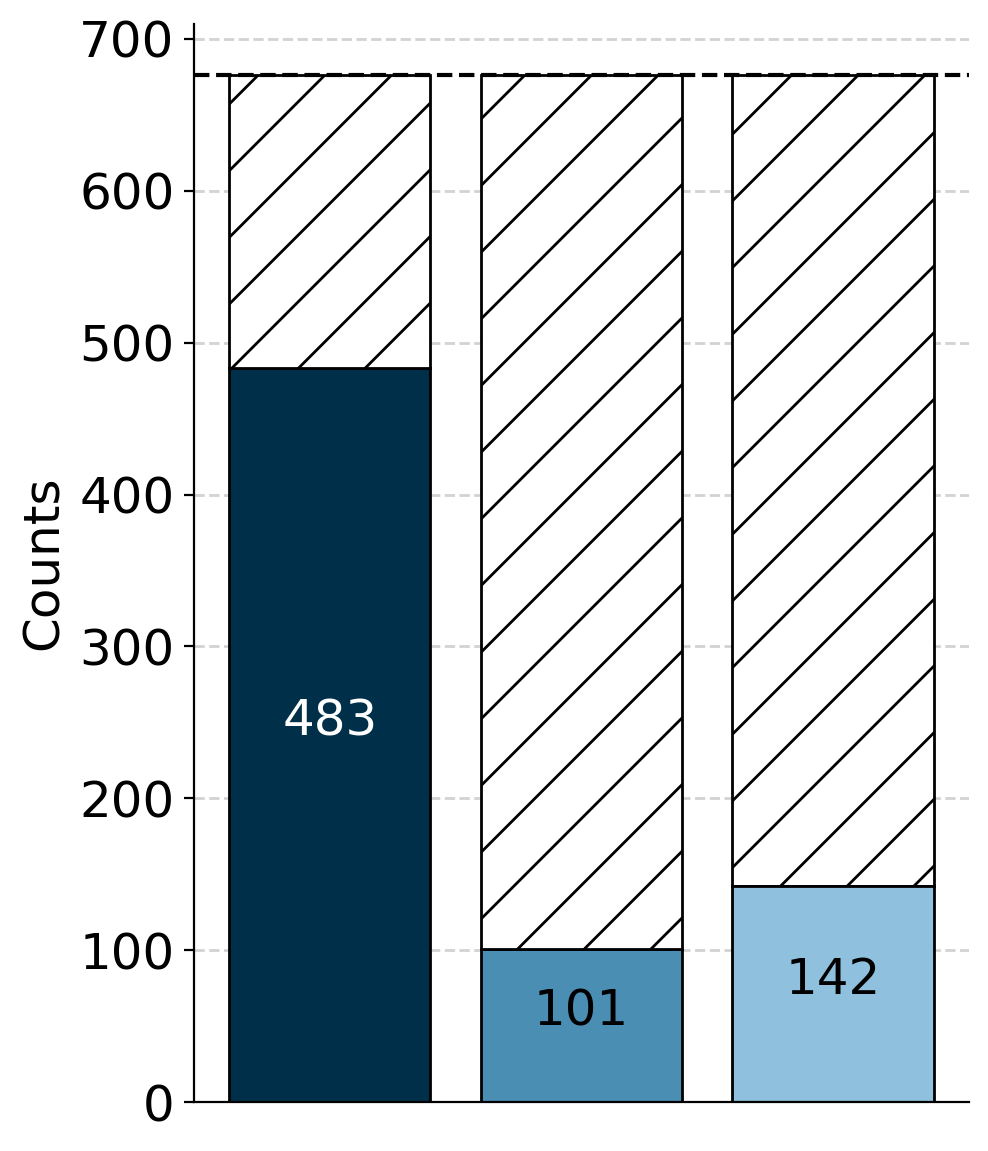

In [33]:
barplot("phylum", "Negarnaviricota")

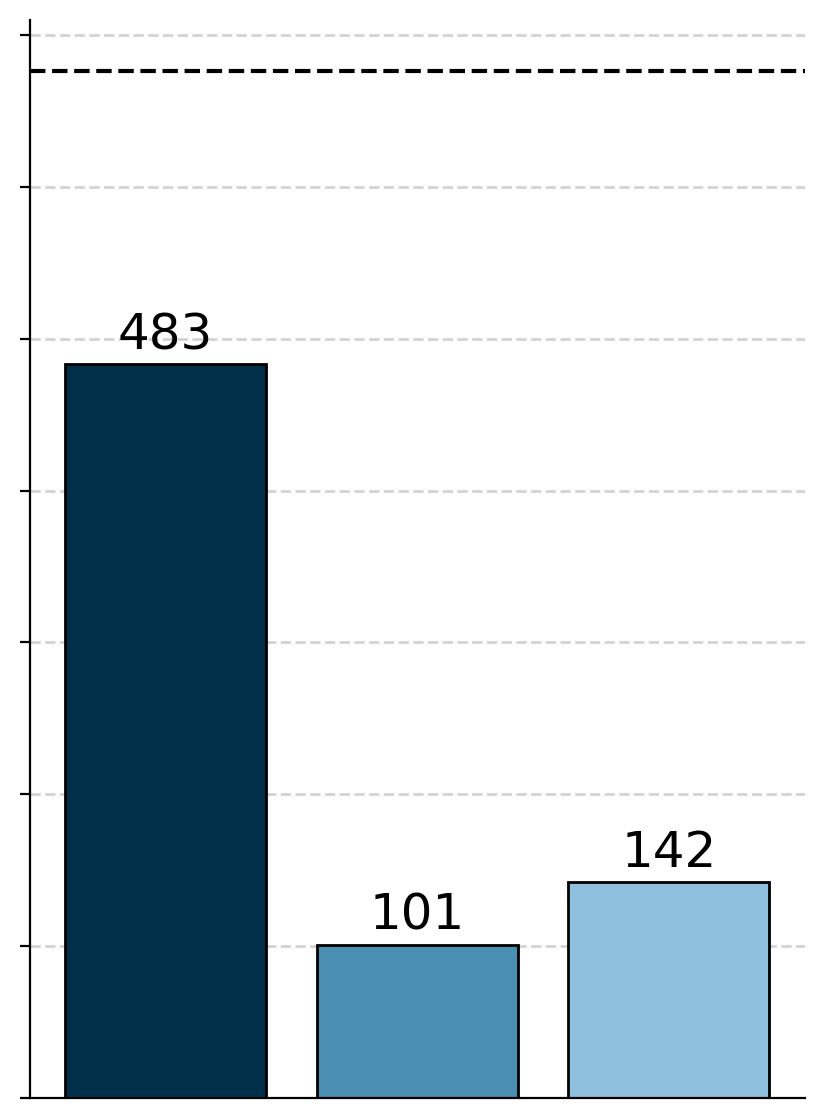

In [34]:
barplot("class", "Monjiviricetes")

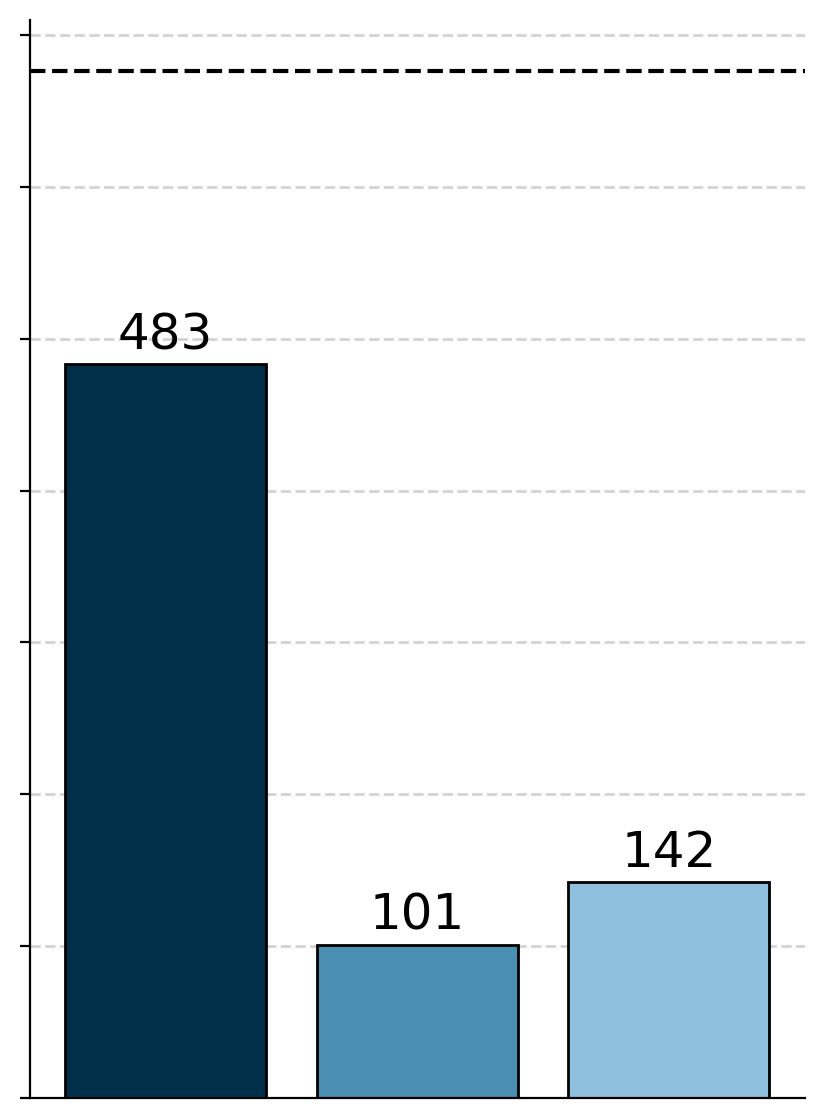

In [35]:
barplot("order", "Mononegavirales")

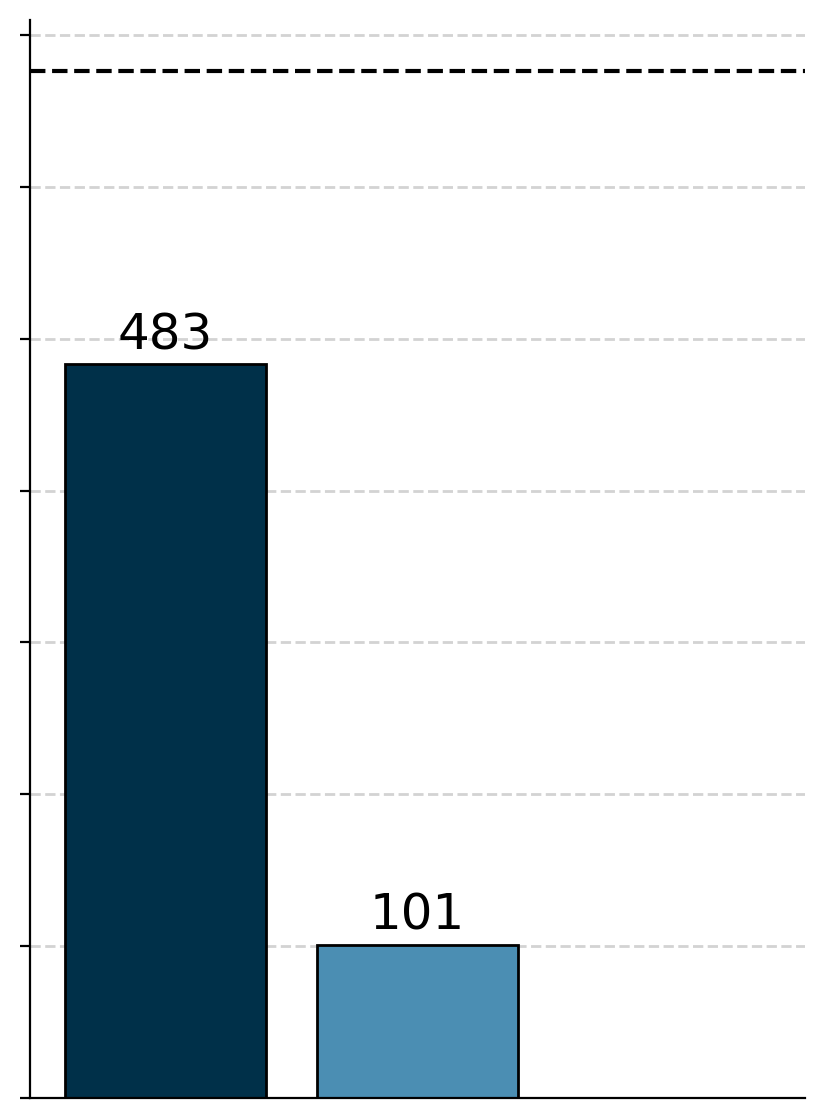

In [36]:
barplot("family", "Filoviridae")

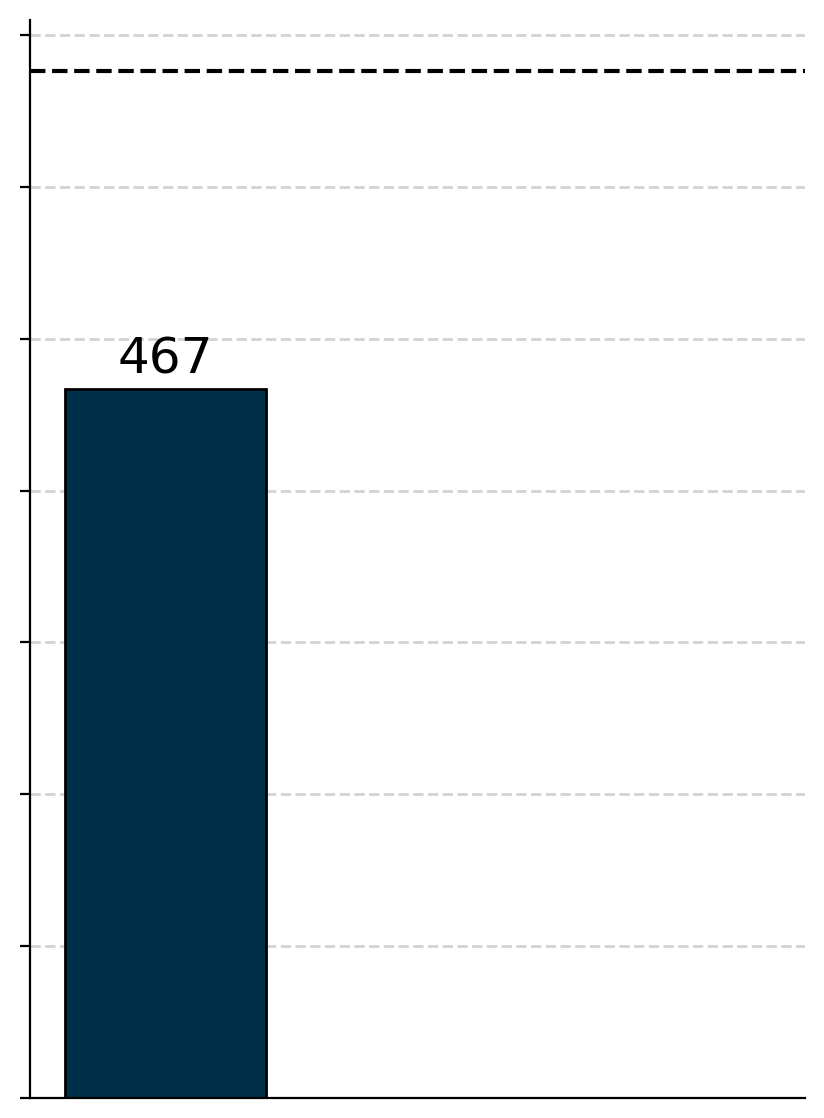

In [37]:
barplot("genus", "Ebolavirus")

In [38]:
def barplot_incorrects(tax_level, expected_tax):
    fig, ax = plt.subplots(figsize=(5,7))
    fontsize=18

    correct = adata2[:, adata2.var.index.isin(taxmap[taxmap[tax_level].isin(expected_tax)]["rep_ID"].unique())].X.sum()
    ax.bar(0, correct, color=colors[0], edgecolor="black")
    if correct > 0:
        ax.text(0, correct+10, str(int(correct)), fontsize=fontsize, ha="center")


    correct = adata[:, adata.var.index.isin(taxmap[taxmap[tax_level].isin(expected_tax)]["rep_ID"].unique())].X.sum()
    ax.bar(1, correct, color=colors[1], edgecolor="black")
    if correct > 0:
        ax.text(1, correct+10, str(int(correct)), fontsize=fontsize, ha="center")

    correct = adata3[:, adata3.var.index.isin(taxmap[taxmap[tax_level].isin(expected_tax)]["rep_ID"].unique())].X.sum()
    ax.bar(2, correct, color=colors[2], edgecolor="black")
    if correct > 0:
        ax.text(2, correct+10, str(int(correct)), fontsize=fontsize, ha="center")

    ax.axhline(total, color="black", ls="--")

    # x_labels = ["All Ebolavirus\nspecies excluded", "All Ebolavirus\ngenera excluded", "All Filoviridae\nexcluded"]
    # ax.set_xticks([0,1,2], x_labels)
    ax.set_xticks([])

    if tax_level == "phylum":
        ax.set_ylabel("Counts", fontsize=fontsize)
    else:
        ax.set_yticks([0,100,200,300,400,500,600,700], ["","","","","","","",""])

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.tick_params(axis="both", labelsize=fontsize)

    ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
    ax.set_axisbelow(True)

    plt.savefig(f"targets_removed_offtarget_{tax_level}_{expected_tax[0]}.png", dpi=300, bbox_inches="tight")

    fig.show()

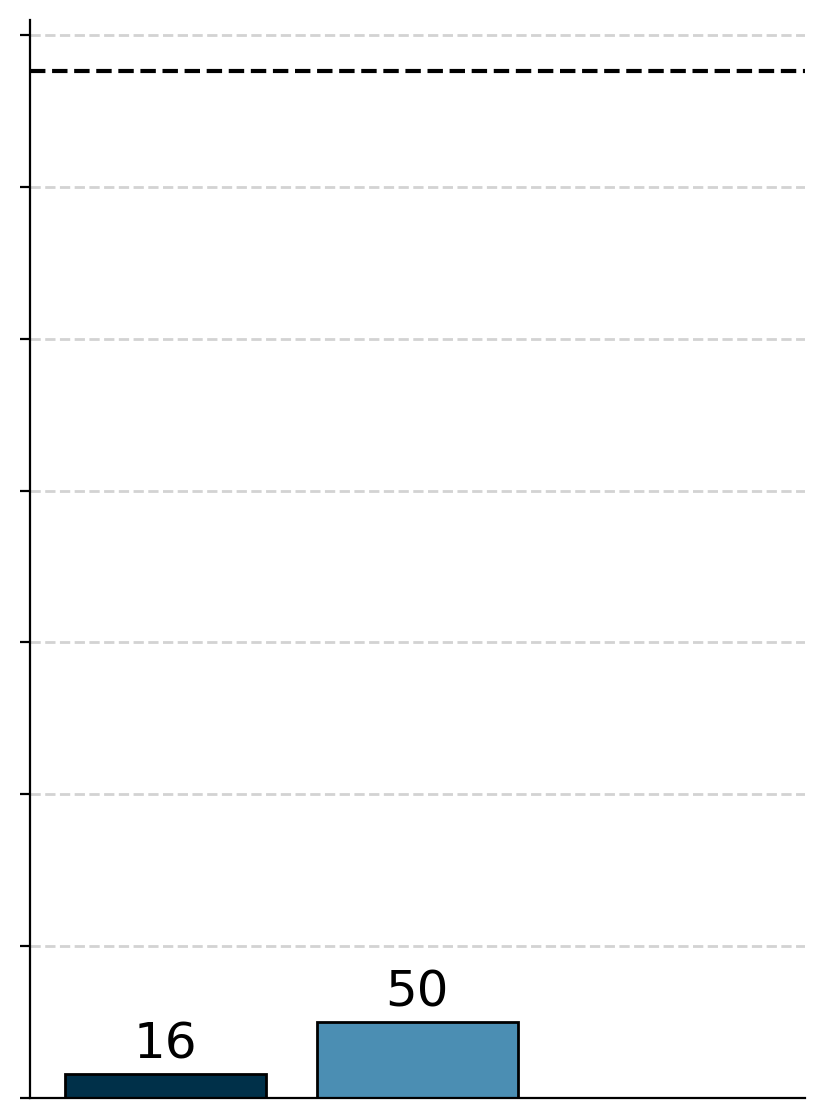

In [39]:
barplot_incorrects("species", ["Marburg marburgvirus"])

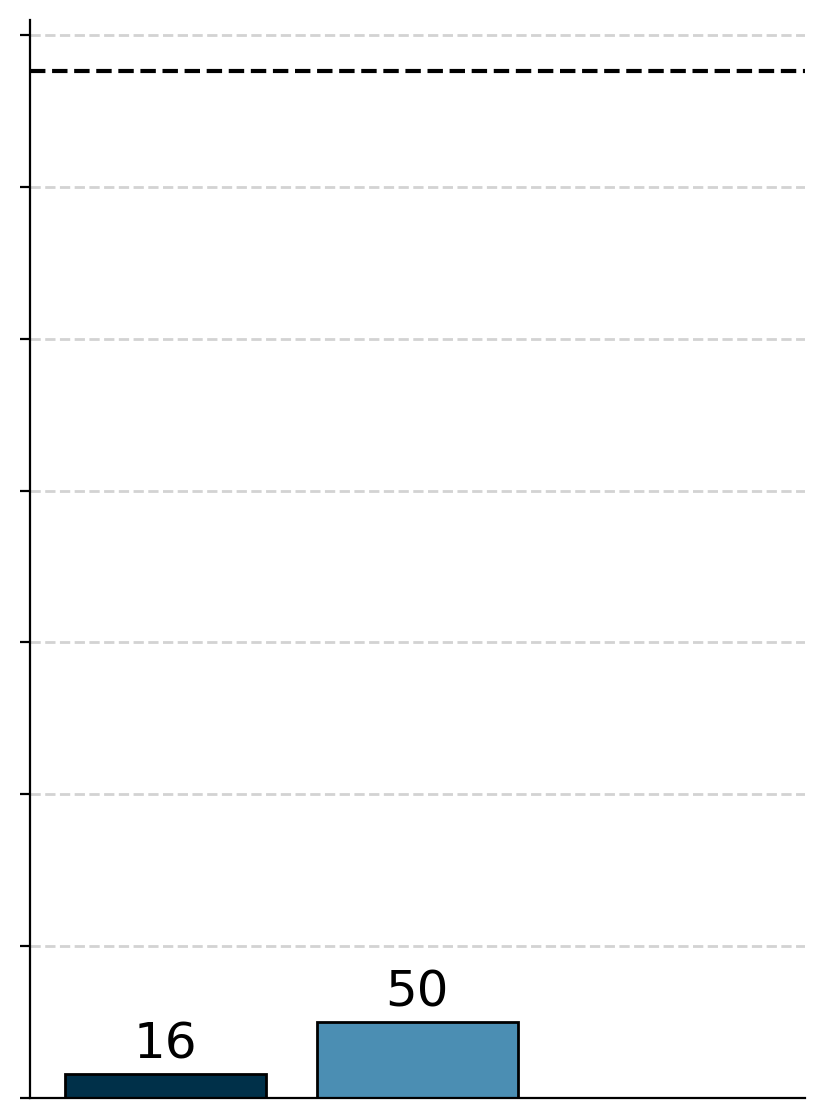

In [40]:
barplot_incorrects("genus", ["Marburgvirus"])

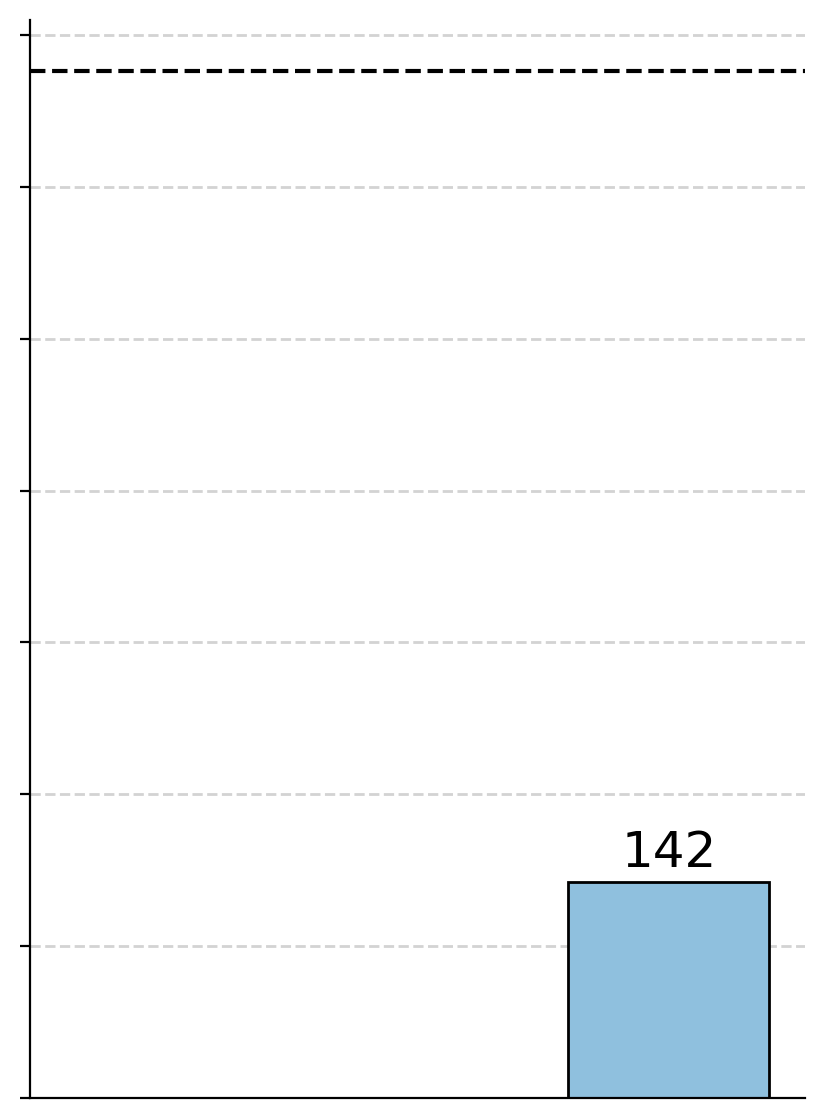

In [41]:
barplot_incorrects("family", ["Paramyxoviridae"])

In [42]:
def barplot_incorrects2(tax_level1, expected_tax1, tax_level2, expected_tax2):
    fig, ax = plt.subplots(figsize=(5,7))
    fontsize=18

    correct = adata2[:, adata2.var.index.isin(taxmap[(taxmap[tax_level1].isin(expected_tax1)) & (taxmap[tax_level2].isin(expected_tax2))]["rep_ID"].unique())].X.sum()
    ax.bar(0, correct, color=colors[0], edgecolor="black")
    if correct > 0:
        ax.text(0, correct+10, str(int(correct)), fontsize=fontsize, ha="center")


    correct = adata[:, adata.var.index.isin(taxmap[(taxmap[tax_level1].isin(expected_tax1)) & (taxmap[tax_level2].isin(expected_tax2))]["rep_ID"].unique())].X.sum()
    ax.bar(1, correct, color=colors[1], edgecolor="black")
    if correct > 0:
        ax.text(1, correct+10, str(int(correct)), fontsize=fontsize, ha="center")

    correct = adata3[:, adata3.var.index.isin(taxmap[(taxmap[tax_level1].isin(expected_tax1)) & (taxmap[tax_level2].isin(expected_tax2))]["rep_ID"].unique())].X.sum()
    ax.bar(2, correct, color=colors[2], edgecolor="black")
    if correct > 0:
        ax.text(2, correct+10, str(int(correct)), fontsize=fontsize, ha="center")

    ax.axhline(total, color="black", ls="--")

    # x_labels = ["All Ebolavirus\nspecies excluded", "All Ebolavirus\ngenera excluded", "All Filoviridae\nexcluded"]
    # ax.set_xticks([0,1,2], x_labels)
    ax.set_xticks([])

    ax.set_yticks([0,100,200,300,400,500,600,700], ["","","","","","","",""])

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.tick_params(axis="both", labelsize=fontsize)

    ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
    ax.set_axisbelow(True)

    plt.savefig(f"targets_removed_offtarget_{tax_level1}_{tax_level2}.png", dpi=300, bbox_inches="tight")

    fig.show()

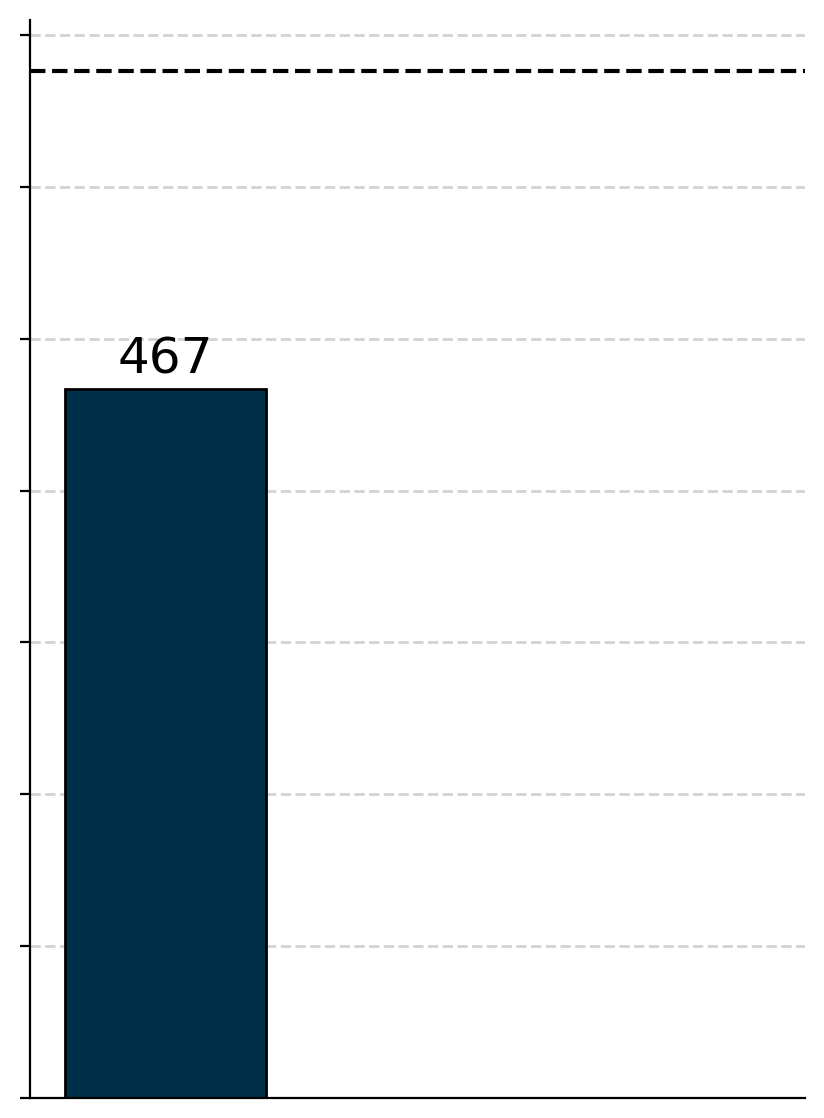

In [43]:
barplot_incorrects2("genus", ["Ebolavirus"], "species", ["."])

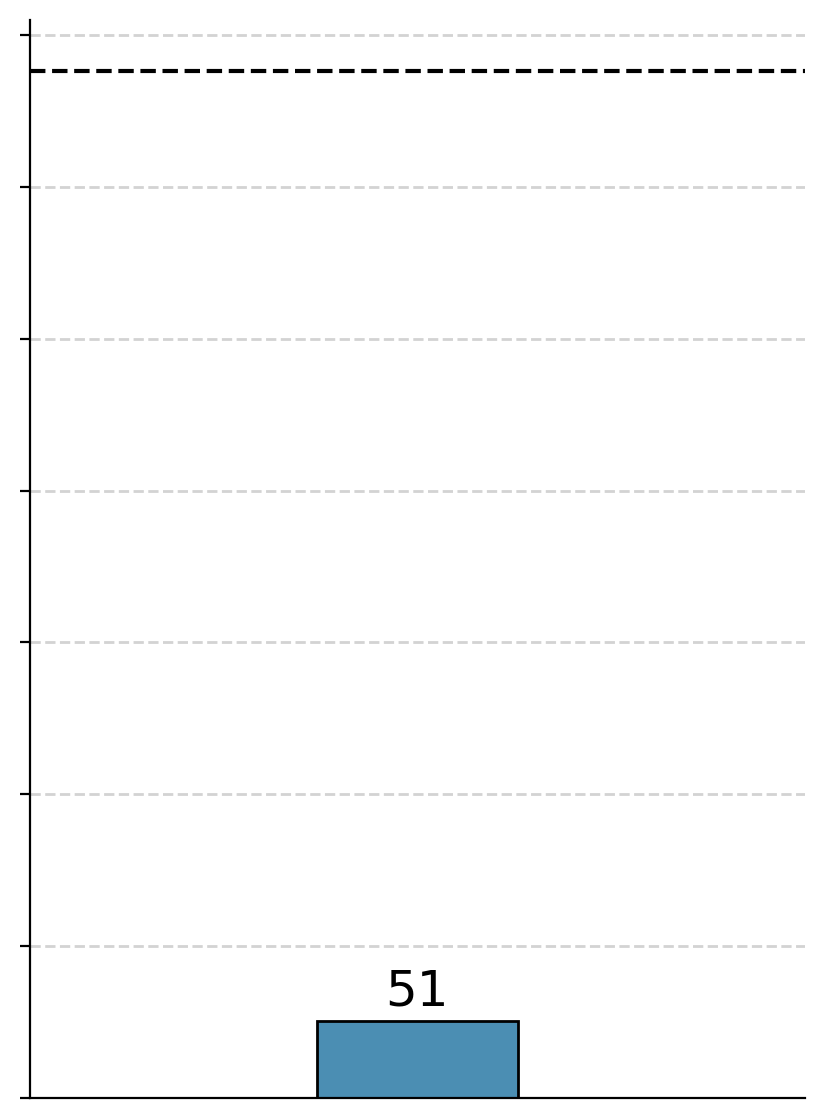

In [44]:
barplot_incorrects2("genus", ["."], "species", ["."])